<a href="https://colab.research.google.com/github/HuyenNguyenHelen/LING-5412/blob/main/Assignment3_LinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Importing libraries that will be used 
import numpy as np
import tarfile
import glob
import re
import pandas as pd
#from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading the dataset

In [25]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/scale_data.tar.gz

--2021-10-13 23:19:32--  http://www.cs.cornell.edu/people/pabo/movie-review-data/scale_data.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4029756 (3.8M) [application/x-gzip]
Saving to: ‘scale_data.tar.gz.1’

scale_data.tar.gz.1 100%[===================>]   3.84M  17.2MB/s    in 0.2s    

2021-10-13 23:19:33 (17.2 MB/s) - ‘scale_data.tar.gz.1’ saved [4029756/4029756]



In [26]:
# Untar the dataset
my_tar = tarfile.open('/content/scale_data.tar.gz')
my_tar.extractall('/content/') 
my_tar.close()


In [4]:
id, review, rating, cl_3, cl_4 = [],[],[],[], []
for root in glob.glob ('/content/scaledata/*'):
  for path in glob.glob(root+'/*'): 
      fo = open(path)
      doc = fo.read()
      if 'id' in path:
        id.extend(doc.split('\n'))
      elif 'subj' in path:
          review.extend(doc.split('\n'))
      elif 'rating' in path:
        rating.extend(doc.split('\n'))
      elif '3class' in path:
        cl_3.extend(doc.split('\n'))
      else:
        cl_4.extend(doc.split('\n'))
      # print(path,'\n')
      # print(doc.split('\n')[:10])
print (len(id), len(review), len(rating), len(cl_3), len(cl_4))

df = pd.DataFrame(zip(id, review, rating, cl_3, cl_4), columns = ['id', 'review', 'rating', '3class', '4class'])
data = df[['review', '3class', '4class']].dropna()
data

5010 5010 5010 5010 5010


,review,3class,4class
0,i'm guessing -- and from the available evidenc...,0,0
1,"there's bad buzz , and then there's the the ba...",0,0
2,director : richard rush . director richard rus...,0,0
3,screenplay : johnny brennan & kamal ahmed and ...,0,0
4,screenplay : tim burns & tom stern and anthony...,0,0
...,...,...,...
5005,"since the film didn't have a director , the fi...",2,3
5006,claire denis ( i can't sleep/nenette and boni/...,2,3
5007,the young kid doesn't know what to say . yang-...,2,3
5008,the film's theme is about how women are made t...,2,3


# Pre-processing the data

In [5]:
data['3class'].value_counts()

1    1915
2    1894
0    1197
        4
Name: 3class, dtype: int64

In [6]:
data = data[data['3class']!='']


In [7]:
# Spliting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split (data['review'], data['3class'] , train_size = 0.8, random_state = 42, shuffle = True, stratify=data['3class'])
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004,) (4004,)
Shapes of X_test, y_test:  (1002,) (1002,)


In [8]:
# Vectorizing the documents
vectorizer = CountVectorizer(binary = True)
X_train = vectorizer.fit_transform(X_train.to_list())
X_test = vectorizer.transform(X_test.to_list())
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004, 38553) (4004,)
Shapes of X_test, y_test:  (1002, 38553) (1002,)


# Linear models

### Default

In [9]:
def printing_eval_scores (y_true, y_pred, report=''):
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'weighted')
  recall = sklearn.metrics.recall_score(y_true, y_pred, average = 'weighted')
  f1 = sklearn.metrics.f1_score(y_true, y_pred, average = 'weighted')
  print('accuracy score: {:.3f}'.format(accuracy))
  print('precision score: {:.3f}'.format(precision))
  print('recall score: {:.3f}'.format(recall))
  print('F1 score: {:.3f}'.format(f1))
  if report is True:
    print(classification_report(y_true, y_pred))
  else:
    pass
  return accuracy, precision, recall, f1

In [10]:

def training (penalty, max_iter): #penalty="l2", max_iter=100
  SGD = SGDClassifier( penalty=penalty, max_iter=max_iter, shuffle=True).fit(X_train, y_train)
  y_pred = SGD.predict(X_test)
  printing_eval_scores (y_test, y_pred, report=True)

penalties = ['l1','l2']
for penalty in penalties:
  print('\n-------training linear model with penalty = {}'.format(penalty ))
  training (penalty='l2', max_iter=100)


-------training linear model with penalty = l1
accuracy score: 0.635
precision score: 0.641
recall score: 0.635
F1 score: 0.635
              precision    recall  f1-score   support

           0       0.63      0.51      0.56       240
           1       0.55      0.64      0.59       383
           2       0.74      0.71      0.72       379

    accuracy                           0.63      1002
   macro avg       0.64      0.62      0.63      1002
weighted avg       0.64      0.63      0.64      1002


-------training linear model with penalty = l2
accuracy score: 0.656
precision score: 0.654
recall score: 0.656
F1 score: 0.655
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       240
           1       0.59      0.57      0.58       383
           2       0.74      0.77      0.75       379

    accuracy                           0.66      1002
   macro avg       0.65      0.65      0.65      1002
weighted avg       0.65      0.66  

Penalty = L2, and loss = log (logistic regression model) yeild the best performance on F1 score (0.657)

### Searching the best parameter

In [11]:
# Set the parameters by cross-validation
tuned_parameters = [{'alpha': [i for i in np.arange (0.0001, 0.01, 0.001 )]}] #, 'loss': ['log','hinge', 'perceptron']}]
score = 'f1'

print("# Searching hyper-parameters for %s" % score)
clf = GridSearchCV(SGDClassifier(shuffle=True), tuned_parameters, scoring='%s_macro' % score, cv = 5, refit = True, n_jobs = -1 )
clf.fit(X_train, y_train)
print('Best parameters set found on development set: {}'.format(clf.best_params_))
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

y_pred =  clf.predict(X_test)
printing_eval_scores (y_test, y_pred, report=True)



# Searching hyper-parameters for f1
Best parameters set found on development set: {'alpha': 0.0081}
Grid scores on development set:
accuracy score: 0.647
precision score: 0.643
recall score: 0.647
F1 score: 0.645
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       240
           1       0.59      0.57      0.58       383
           2       0.72      0.77      0.75       379

    accuracy                           0.65      1002
   macro avg       0.64      0.64      0.64      1002
weighted avg       0.64      0.65      0.64      1002



(0.6467065868263473,
 0.6434827278934763,
 0.6467065868263473,
 0.6445894980483167)

**(4)  SGDClassifier used “one versus all” (OVA) strategy to handle multi-class strategy. For each of K classes, the binary classifier will try to predict that class and the rest other K-1 classes.**

In [16]:
# Printing features with highest weights.
best_SGD = SGDClassifier( penalty='l2',  shuffle=True, alpha=0.0081).fit(X_train, y_train)
y_pred = best_SGD.predict(X_test)
weights = best_SGD.coef_
weights

array([[ 0.02465781, -0.04068539, -0.00739734, ...,  0.        ,
        -0.00616445,  0.        ],
       [ 0.02758121, -0.06895304, -0.02758121, ..., -0.01541303,
         0.00243364, -0.01379061],
       [-0.06593266,  0.11131487,  0.05308863, ...,  0.0162691 ,
         0.00342507,  0.        ]])

In [20]:
features = vectorizer.get_feature_names()

feature_weights = {}
for i in range(len(weights)):
  print('\n==============================================')
  print ('\nclass: {}'.format(i+1))
  for w in range(len(weights[i])):
     feature_weights[features[w]] = np.abs(weights[i][w])
  # Sorting the dictionary in descending order
  sorted_feature_weights = {k:v for k, v in sorted(feature_weights.items(), key = lambda item: item[1], reverse=True)}

  # Print the weights learned for each class
  print('10 most important features (in descending order): ')
  for k, v in list(sorted_feature_weights.items())[:20]:
    print ('{}: {:.5f}'. format(k,v))




class: 1
10 most important features (in descending order): 
boring: 0.27124
ridiculous: 0.25891
satisfying: 0.25028
fine: 0.24781
bad: 0.24165
flat: 0.23548
fans: 0.22562
awake: 0.22439
unfunny: 0.21452
watchable: 0.21329
poorly: 0.21206
effective: 0.20466
worst: 0.19850
inane: 0.19850
problems: 0.19850
routine: 0.19850
fascinating: 0.19726
able: 0.19726
inspired: 0.18740
unbelievable: 0.18740


class: 2
10 most important features (in descending order): 
thumbs: 0.32043
add: 0.29690
problem: 0.27825
able: 0.27094
unfortunately: 0.25797
terrific: 0.25310
frustrating: 0.24904
sadly: 0.24823
awake: 0.24823
difficult: 0.24742
changes: 0.23850
masterpiece: 0.23201
choose: 0.23201
problems: 0.22876
albeit: 0.22795
perfect: 0.22552
promise: 0.22308
though: 0.22065
nice: 0.21740
fits: 0.21497


class: 3
10 most important features (in descending order): 
unfortunately: 0.28856
great: 0.27229
interesting: 0.26801
thumbs: 0.24917
flat: 0.22777
perfect: 0.22263
seriously: 0.21664
masterpiece: 0.

**Q6. How does the hyperplane of the classifier look like?**

In [21]:
import seaborn as sns
# sns.displot(weights)
hyperplane = best_SGD.decision_function(X_train).T
#sns.displot(np.flatnonzero(hyperplane))
hyperplane

array([[-1.11012923, -0.97204547, -1.88068593, ..., -1.2469801 ,
        -1.63534067, -2.71412005],
       [ 1.02220888,  0.94271008, -1.08369796, ..., -0.99284219,
        -1.0731522 , -1.02610189],
       [-1.1722495 , -1.29897721,  1.08487364, ...,  0.94787072,
         1.03435381,  1.24413954]])

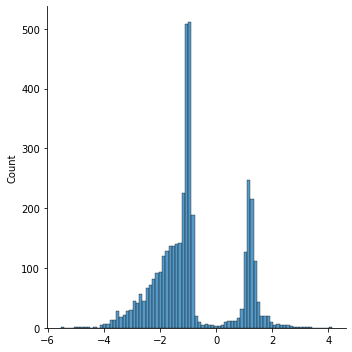

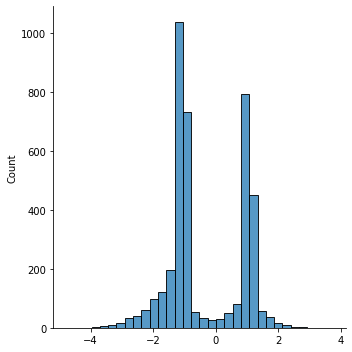

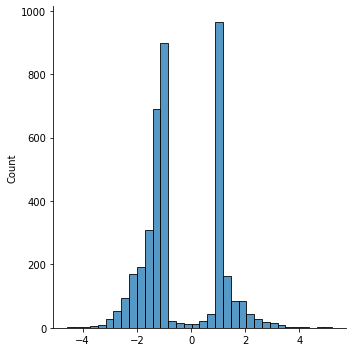

In [22]:
for i in range(3):
  sns.displot(hyperplane[i], kind = 'hist')


**Q7. Model with log loss function**

In [23]:
log_SGD = SGDClassifier(loss='log', penalty='l2',  shuffle=True, alpha=0.0081).fit(X_train, y_train)
y_pred = log_SGD.predict(X_test)
printing_eval_scores (y_test, y_pred, report=True)


accuracy score: 0.671
precision score: 0.671
recall score: 0.671
F1 score: 0.670
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       240
           1       0.60      0.64      0.62       383
           2       0.74      0.77      0.76       379

    accuracy                           0.67      1002
   macro avg       0.67      0.66      0.66      1002
weighted avg       0.67      0.67      0.67      1002



(0.6706586826347305, 0.670792722809262, 0.6706586826347305, 0.6695513891393804)

**8. Building a linear model to compare the result**

In [27]:
df = pd.DataFrame(zip(id, review, rating, cl_3, cl_4), columns = ['id', 'review', 'rating', '3class', '4class'])
new_df = df[['review', 'rating']].dropna()
new_df['review']  =new_df['review']

,review,rating
0,i'm guessing -- and from the available evidenc...,0
1,"there's bad buzz , and then there's the the ba...",0
2,director : richard rush . director richard rus...,0
3,screenplay : johnny brennan & kamal ahmed and ...,0
4,screenplay : tim burns & tom stern and anthony...,0.1
...,...,...
5005,"since the film didn't have a director , the fi...",0.9
5006,claire denis ( i can't sleep/nenette and boni/...,0.9
5007,the young kid doesn't know what to say . yang-...,0.9
5008,the film's theme is about how women are made t...,0.9
